In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL as pl
from PIL import Image, ImageFilter
import ezdxf
from scipy.interpolate import interp1d

In [112]:
#calculating calibration matrix
import numpy as np
def rot_x(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[1, 0, 0], [0, cosa, -sina], [0, sina, cosa]])

def rot_y(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[cosa, 0, sina], [0, 1, 0], [-sina, 0, cosa]])

def rot_z(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])

rot_x_1 = rot_x(0)
rot_y_1 = rot_y(0)
rot_z_1 = rot_z(0)

rot_1 = rot_x_1 * rot_y_1 * rot_z_1

trans_1 = np.array([[212], [0], [0]])

I3 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

K1 = np.array([[1.36812029e+04, 0.00000000e+00, 2.66351290e+03],
 [0.00000000e+00, 9.71941261e+03, 1.60272117e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
     

P1 = np.dot(K1, np.dot(rot_1, np.hstack((I3, trans_1))))
cameraMatrix = P1
dist = [[ 3.58620205e+00, -4.77633812e+01,  6.69321996e-02,  1.35928716e-01,2.94972915e+02]]#[[-0.17793447, 0.22376621, 0.00098179, 0.00145806, -0.08411422]]

# [[1.36812029e+04 0.00000000e+00 2.66351290e+03]
#  [0.00000000e+00 9.71941261e+03 1.60272117e+03]
#  [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
# [[ 3.58620205e+00 -4.77633812e+01  6.69321996e-02  1.35928716e-01
#    2.94972915e+02]]

In [113]:
# # Uploda an image and undistorts it

# # Load the image
# img = cv2.imread("../data/test1.png")

# # Optimize camera matrix
# h,  w = img.shape[:2]
# newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))

# # Undistort
# dst = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

# # crop the image
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]
# cv2.imwrite('caliResult1.png', dst)


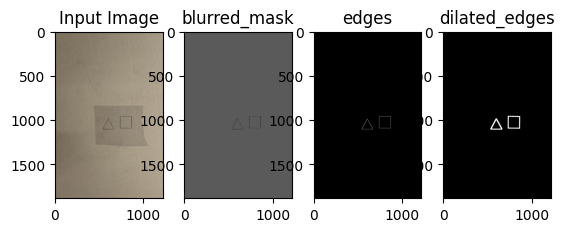

In [114]:
"""
# For collored lines only (green)
# Convert img to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of green color in HSV
lower_green = np.array([40, 50, 50])
upper_green = np.array([90, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)"""

img = cv2.imread("../data/line_detection_test_calib.png")

 
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# Img to grayscale
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# Threshold the image to get only the black lines
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 90, cv2.THRESH_BINARY)

blurred_mask = cv2.GaussianBlur(blackAndWhiteImage,  (3, 3), sigmaX=3)#zamenjaj thresh za mask ce zelis barvne crte
# plt.subplot(121), plt.imshow(blackAndWhiteImage)
# plt.subplot(122), plt.imshow(blurred_mask)

# Canny edge detections
edges = cv2.Canny(blurred_mask, 10, 200)

# Kernel for morphological operations
kernel = np.ones((9,9), np.uint8)

# Dilate the edges
dilated_edges = cv2.dilate(edges, kernel, iterations=1)


# Erode the edges
# eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)
# erode_edges = cv2.erode(eroded_edges, kernel, iterations=1)

# Display the input and output images
plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Input Image')
plt.subplot(142), plt.imshow(cv2.cvtColor(blurred_mask, cv2.COLOR_GRAY2RGB)), plt.title('blurred_mask')
plt.subplot(143), plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)), plt.title('edges')
plt.subplot(144), plt.imshow(cv2.cvtColor(dilated_edges, cv2.COLOR_BGR2RGB)), plt.title('dilated_edges')
plt.show()

# Display the result
cv2.imwrite("..\data\edge_detection.png", dilated_edges)
cv2. destroyAllWindows()


In [115]:
# Scale dxf to apropriat size
def scale_png(png_file, scale_factor):
    # Load the PNG image
    image = cv2.imread(png_file)

    # Img dimensons
    height, width, _ = image.shape

    # Compute the new dimensions after scaling
    new_width = int(width * scale_factor_x)
    new_height = int(height * scale_factor_y)

    # Resize
    resized_image = cv2.resize(image, (new_width, new_height))

    scaled_png_file = png_file.replace(".png", "_scaled.png")
    cv2.imwrite(scaled_png_file, resized_image)

    return scaled_png_file

png_file = "..\\data\\edge_detection.png"
scale_factor_y = 0.701754386  # Scaling factor of 0.5 (50% reduction)
scale_factor_x = 0.717
scaled_png_file = scale_png(png_file, scale_factor_y)

In [116]:
# Convert .png to dxf

image = cv2.imread("..\data\edge_detection_scaled.png", cv2.IMREAD_GRAYSCALE)

# Grayscale
_, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Finds contures
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# DXF risba in dodaj sloj za konture
doc = ezdxf.new(dxfversion='R2010')
msp = doc.modelspace()

# draw contures
for contour in contours:
    points = np.squeeze(contour)
    msp.add_lwpolyline(points, format='xyseb')

doc.saveas("..\\data\\rezultat_calib.dxf")

In [117]:
# Conect all non connected lines
def close_lines(dxf_file):
    doc = ezdxf.readfile(dxf_file)
    msp = doc.modelspace()

    for entity in msp:
        if entity.dxftype() == 'LWPOLYLINE' and not entity.closed:
            points = entity.get_points()

            # Check if the start and end points are different
            start = points[0]
            end = points[-1]
            if start != end:
                # Add the start point to the end of the points list
                points.append(start)
                # Update the points of the polyline
                entity.set_points(points)
                # Close the polyline
                entity.closed = True

    doc.saveas(dxf_file)

dxf_file = "..\\data\\rezultat_connected.dxf"
close_lines(dxf_file)
